# Прогнозирование электропотребления в регионе

**Задача:**  
Разработка модели прогнозирования общего энергопотребления региона на каждый час, в МВт*ч

**Цель:**  
Разработать надежную и точную модель прогнозирования объема
энергопотребления на сутки для Калининградской области с использованием
доступных исторических данных 


**Данные:**

- `train_dataset.csv` – исторические данные о потреблении энергии за период 2019-01-01 - 2023-03-31
     * *date* – дата;
     * *time* – время,  время  представлено  в  диапазоне  0  –  23,  что  означает  24 часа в сутках;
     * *target* – фактическое потребление на указанную дату;
     * *temp* – фактическая температура на указанную дату;
     * *temp_pred* – прогноз температуры на указанную дату;
     * *weather_fact* – фактическая погода на указанную дату;
     * *weather_pred* – прогноз погоды на указанную дату;


- `test_dataset.csv` – исторические данные о потреблении энергии за период 2023-04-01 – 2023-07-31


**Метрики качества**:
- MAE (Главная метрика)
- MAPE (Вспомогательная метрика)
- R2-score (Вспомогательная метрика)


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-общий-обзор-данных" data-toc-modified-id="Загрузка-и-общий-обзор-данных-1">Загрузка и общий обзор данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2">Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Признаки" data-toc-modified-id="Признаки-2.1">Признаки</a></span></li><li><span><a href="#Исследование-временного-ряда" data-toc-modified-id="Исследование-временного-ряда-2.2">Исследование временного ряда</a></span></li><li><span><a href="#Обработка-текстовых-признаков-'weather_pred'" data-toc-modified-id="Обработка-текстовых-признаков-'weather_pred'-2.3">Обработка текстовых признаков 'weather_pred'</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-2.4">Feature engineering</a></span></li><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-2.5">Корреляционный анализ</a></span></li></ul></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-3">Моделирование</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.1">LGBMRegressor</a></span></li><li><span><a href="#Stacking--с-LGBM" data-toc-modified-id="Stacking--с-LGBM-3.2">Stacking  с LGBM</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3.3">Тестирование</a></span></li><li><span><a href="#Оценка-важности-признаков" data-toc-modified-id="Оценка-важности-признаков-3.4">Оценка важности признаков</a></span></li></ul></li><li><span><a href="#Выводы-и-резюме" data-toc-modified-id="Выводы-и-резюме-4">Выводы и резюме</a></span><ul class="toc-item"><li><span><a href="#main.py" data-toc-modified-id="main.py-4.1">main.py</a></span></li></ul></li></ul></div>

In [1]:
# requirments.txt для ноутбука
# !pip install pandas==2.0.0 
# !pip install numpy==1.23.5 
# !pip install seaborn==0.11.1 
# !pip install phik==0.10.0 
# !pip install sklearn==1.2.2 
# !pip install statsmodels==0.13.2 
# !pip install lightgbm==3.3.5 
# !pip install joblib==1.2.0 
# !pip install matplotlib==3.7.1 
# !pip install nltk==3.8.1

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

import warnings
import phik
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from phik import phik_matrix

from lightgbm import LGBMRegressor
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import  CountVectorizer
from datetime import timedelta
from sklearn.ensemble import StackingRegressor

warnings.filterwarnings('ignore')

seed = 42

## Загрузка и общий обзор данных
Загрузим исходные данные и выведем первичную информацию о данных. 
Признаку дата сразу присвоим тип данных datetime.

In [2]:
try:
    data_train = pd.read_csv('train_dataset.csv', parse_dates=['date'])
    data_test = pd.read_csv('test_dataset.csv', parse_dates=['date'])
except:
    print('Проверьте путь к файлу')

In [4]:
# обучающая выборка
data_train.sample(5)

,date,time,target,temp,temp_pred,weather_pred,weather_fact
29791,2022-05-26,7,372.967,12.3,16.0,"п/обл, 20%",обл. с пр.
22818,2021-08-08,18,433.543,19.6,19.0,"обл с пр, 24%, ветер",дождь
30473,2022-06-23,17,468.594,23.3,22.0,п/обл,ясно
30987,2022-07-15,3,302.823,12.2,13.0,"пасм, 63%, ветер","пасм, дождь"
7024,2019-10-20,16,471.580,15.8,15.0,п/обл,облачно


In [4]:
display(data_train.info(), data_train.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          37224 non-null  datetime64[ns]
 1   time          37224 non-null  int64         
 2   target        37224 non-null  float64       
 3   temp          37224 non-null  float64       
 4   temp_pred     37136 non-null  float64       
 5   weather_pred  37136 non-null  object        
 6   weather_fact  37223 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 2.0+ MB


None

,count,mean,min,25%,50%,75%,max,std
date,37224,2021-02-14 00:00:00,2019-01-01 00:00:00,2020-01-23 00:00:00,2021-02-14 00:00:00,2022-03-09 00:00:00,2023-03-31 00:00:00,NaN
time,37224.0,11.5,0.0,5.75,11.5,17.25,23.0,6.92228
target,37224.0,483.731441,198.982,418.95075,473.064,561.217,767.888,101.459375
temp,37224.0,8.748995,-21.7,2.6,7.9,14.7,32.5,8.125722
temp_pred,37136.0,8.768984,-20.0,3.0,8.0,15.0,33.0,8.01752


In [5]:
# тестовая выборка
display(data_test.info(), data_test.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          2928 non-null   datetime64[ns]
 1   time          2928 non-null   int64         
 2   target        2928 non-null   float64       
 3   temp          2928 non-null   float64       
 4   temp_pred     2904 non-null   float64       
 5   weather_pred  2904 non-null   object        
 6   weather_fact  2928 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 160.2+ KB


None

,count,mean,min,25%,50%,75%,max,std
date,2928,2023-05-31 11:59:59.999999744,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-05-31 12:00:00,2023-07-01 00:00:00,2023-07-31 00:00:00,NaN
time,2928.0,11.5,0.0,5.75,11.5,17.25,23.0,6.923369
target,2928.0,419.467047,264.819,371.38425,431.4775,462.41425,607.474,71.39307
temp,2928.0,13.768613,-3.1,9.2,14.0,18.7,31.7,6.479879
temp_pred,2904.0,13.910124,-3.0,9.0,15.0,19.0,29.0,6.381692


- На первый взгляд все значения признаков корректные:
    - часы в сутках в диапазоне 0-23
    - температуры от -21 до 33 гр.С
    - электропотребление от ~200 до ~770 МВт*ч
- Диапазон дат обучающего датасета - с 1 января 19 года по 31 марта 2023 года.
- Диапазон дат тестового датасета - с 1 апреля 2023 года по 31 июля 2023 года.
- В обоих есть пропуски

In [6]:
# Проверим на наличие явных дубликатов
print('Количество явных дубликатов в выборках:',[df.duplicated().sum() for df in [data_train, data_test]])

Количество явных дубликатов в выборках: [0, 0]


**Пропуски**

In [7]:
print('Количество пропусков в обуч.датасете:', data_train.isna().sum())
print('Количество пропусков в тест.датасете:', data_test.isna().sum())

Количество пропусков в обуч.датасете: date             0
time             0
target           0
temp             0
temp_pred       88
weather_pred    88
weather_fact     1
dtype: int64
Количество пропусков в тест.датасете: date             0
time             0
target           0
temp             0
temp_pred       24
weather_pred    24
weather_fact     0
dtype: int64


Пропуски есть в незначительном количестве. Посмотрим подробнее.

In [8]:
# Выведем строки, которые имеют пропуски:
data_train[data_train[['temp_pred', 'weather_pred']].isnull().any(axis=1)]

,date,time,target,temp,temp_pred,weather_pred,weather_fact
18672,2021-02-17,0,568.658,-4.0,NaN,NaN,облачно
18675,2021-02-17,3,504.264,-6.0,NaN,NaN,облачно
18678,2021-02-17,6,521.233,-10.0,NaN,NaN,облачно
18681,2021-02-17,9,665.486,-9.0,NaN,NaN,облачно
18684,2021-02-17,12,702.568,-5.0,NaN,NaN,облачно
...,...,...,...,...,...,...,...
32937,2022-10-04,9,495.988,14.2,NaN,NaN,пер.обл.
32940,2022-10-04,12,529.651,13.6,NaN,NaN,пер.обл.
32943,2022-10-04,15,514.598,13.4,NaN,NaN,пер.обл.
32946,2022-10-04,18,500.243,8.4,NaN,NaN,пер.обл.


In [9]:
# Проверим, совпадают ли все строки с пропусками в 2-х столбцах:
data_train[['temp_pred', 'weather_pred']].isnull().all(axis=1).value_counts()

False    37136
True        88
Name: count, dtype: int64

Да, 88 строк имеют пропуски сразу в 2 столбцах - 'temp_pred', 'weather_pred'.   

In [10]:
# сгруппируем строки с пропусками по дате и времени
display(data_train[data_train['temp_pred'].isna()].pivot_table(index=['date'], values='target', aggfunc='count'))
display(data_train[data_train['temp_pred'].isna()].pivot_table(index=['time'], values='target', aggfunc='count'))

,target
date,
2021-02-17,8
2022-03-13,8
2022-03-14,8
2022-03-15,8
2022-09-25,8
2022-09-26,8
2022-09-27,8
2022-09-30,8
2022-10-01,8


,target
time,
0,11
3,11
6,11
9,11
12,11
15,11
18,11
21,11


Пропуски есть всего для нескольких дней для одних и тех же часов, не идущих подряд (в тестовой выборке аналогично). В случае погоды  будет приемлемо заполнять пропуски значением в предыдущий час.

In [11]:
# Заменим пропуски значением из предыдущего часа  в 'temp_pred' и 'weather_pred',  а также одно значение weather_fact
data_train[['temp_pred', 'weather_pred', 'weather_fact']] =\
                        data_train[['temp_pred', 'weather_pred', 'weather_fact']].ffill()

data_test[['temp_pred', 'weather_pred', 'weather_fact']] =\
                        data_test[['temp_pred', 'weather_pred', 'weather_fact']].ffill()


---
Итоги общего обзора данных:
1. Исторические данные содержат 7 признаков, обучающий датафрейм состоит из 37224 записей.
2. Период обучающего датасета 4+ года -  01.01.2019 - 31.03.2023, тестового датасета 4 месяца - с 01.04.2023 - 31.07.2023.
3. При первичном ознакомлении с данными дубликатов и выбросов не обнаружено.
4. Были обнаружены пропуски в признаках с погодой 'temp_pred' и 'weather_pred' - в одних и тех же строках, один пропуск в 'weather_fact'. Так как пропуски идут не последовательно, заменябются на значение в предыдущем часе

## Исследовательский анализ данных

In [12]:
# Объединим 2 датасета, что бы исследовать их вместе:
data = pd.concat([data_train, data_test], ignore_index=True)

### Признаки

In [13]:
# уникальные значения 
for col in data:
    print('Количество уникальных значений в', col, ':', len(data[col].value_counts()))

Количество уникальных значений в date : 1673
Количество уникальных значений в time : 24
Количество уникальных значений в target : 37916
Количество уникальных значений в temp : 475
Количество уникальных значений в temp_pred : 54
Количество уникальных значений в weather_pred : 2310
Количество уникальных значений в weather_fact : 632


In [14]:
# функция для графики распределения признаков
def data_graphics(data, bins=100, title='Data', xlabel='value', ylabel='count', 
                  datetime=False, one_graph=False, rotation=0):
    
    cols_count = len(data.columns)
    
    if cols_count == 1:
        data.hist(bins=bins)
        plt.title(title + ' distribution')
        plt.grid(True)
        plt.xlabel(xlabel)
        plt.xticks(rotation = rotation)
        plt.ylabel(ylabel)
        
    else:
        fig, axs = plt.subplots(cols_count, figsize=(7, 10))        
    
        ax_n = 0
        for column in data.columns:
            axs[ax_n].hist(data[column], bins=bins)
            axs[ax_n].title.set_text(column + ' distribution')
            axs[ax_n].grid(True)
            axs[ax_n].set_xlabel(xlabel)
            axs[ax_n].set_ylabel(ylabel)
            axs[ax_n].tick_params('x', labelrotation=rotation)
            ax_n+=1
        fig.tight_layout()


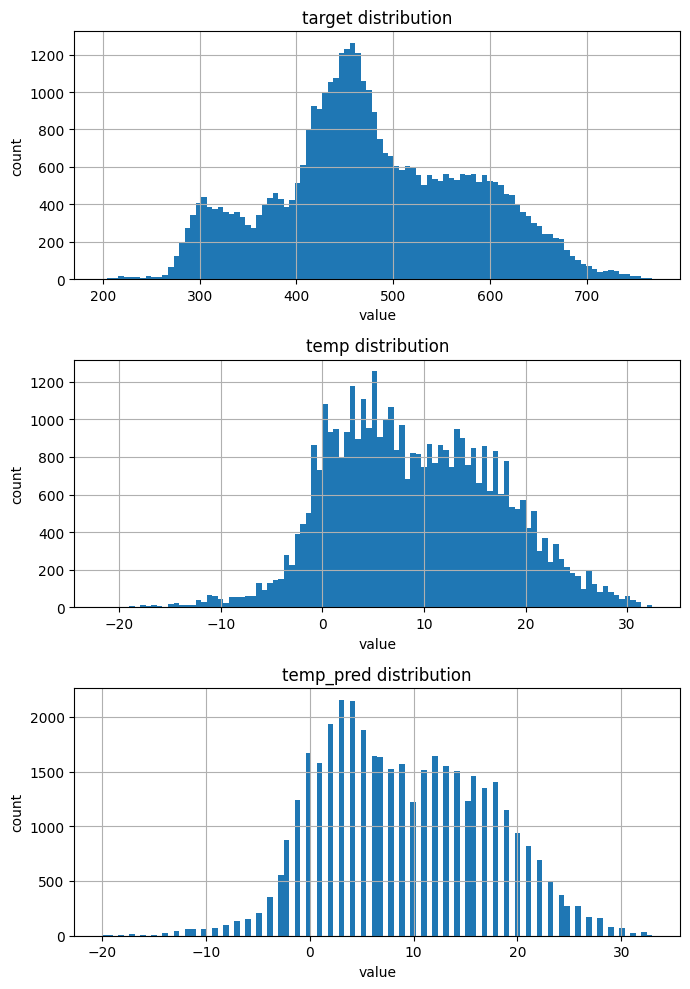

In [15]:
# графики распределения признаков
data_graphics(data[['target', 'temp', 'temp_pred']])

- Данные за 1673 дня
- В признаке с текстовым описанием прогнозируемой погоды 'weather_pred' много уникальных значений  (2191), в признаке с фактической погодой меньше (580). Попробуем обработать текст, чтобы выделить наиболее важжные слова
- Реальная погода - значения распределены дискретно по целым числам, в прогнозируемой также есть промежуточные дробные значения
- В целевом признаке таргет большинство значений находятся в диапазоне ~300-600 МВт*ч


Исследуем данные на наличие **выбросов**:

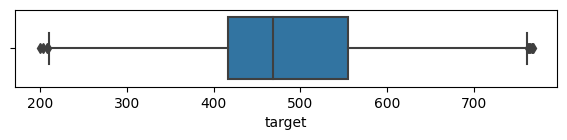

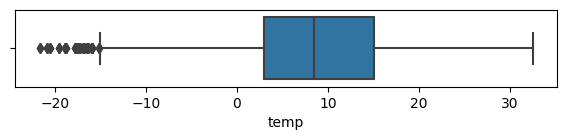

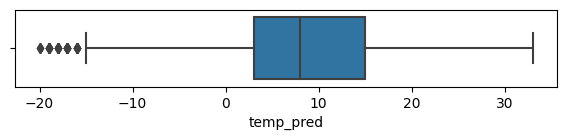

In [16]:
for col in ['target', 'temp', 'temp_pred']:
    plt.figure(figsize=(7, 1))
    sns.boxplot(data[col])
plt.show()

- В целевом признаке значимых выбросов нет.
- В температуре видим естественные выбросы, связанные с малым количеством сильно холодных дней.

### Исследование временного ряда

In [17]:
# проверим последовательность
print(data['date'].is_monotonic_increasing)
# проверим, что во временном ряду нет пропущенных значений
(data.date.max() - data.date.min() + timedelta(days=1)).days * 24, len(data.date.unique()) * 24

True


(40152, 40152)

Временной ряд последовательный, полный, без пропущенных значений.

Посмотрим на распределение энергопотребления во времени.

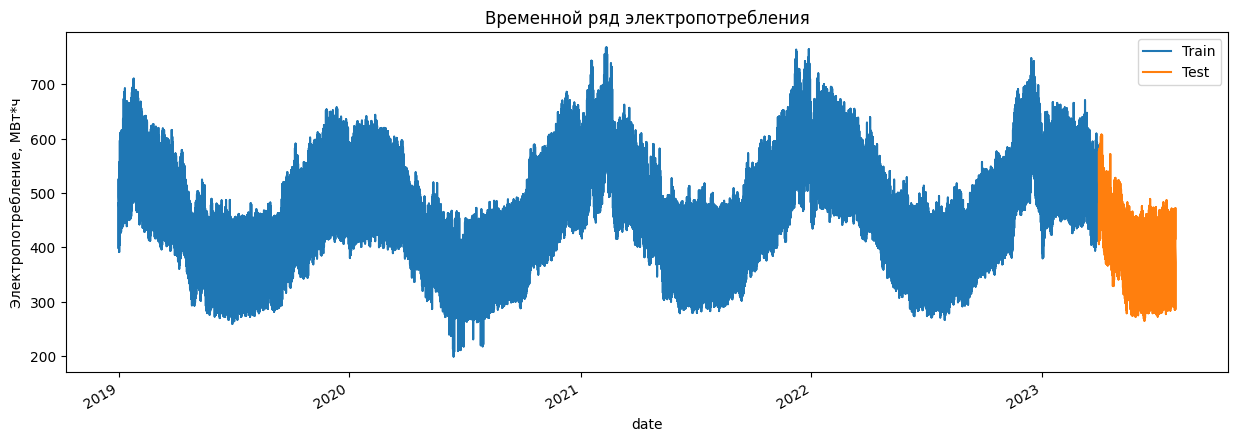

In [18]:
# временной ряд
plt.figure(figsize=(15, 5))
data_train.set_index('date')['target'].plot( label='Train', title='Временной ряд электропотребления')
data_test.set_index('date')['target'].plot(label='Test', ylabel='Электропотребление, МВт*ч')
plt.legend()
plt.show()

In [19]:
#проверка на стационарность ряда
adf_result = adfuller(data.target)

print('Augmneted Dickey_fuller Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('critical values at different levels:')
for k, v in adf_result[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -4.466160
p-value: 0.000226
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


p-value меньше 0.05, статистика ниже critical values. Получили статистически значимые основания считать, что временной ряд стационарен.

Посмотрим декомпозицию ряда, суммируем за день:

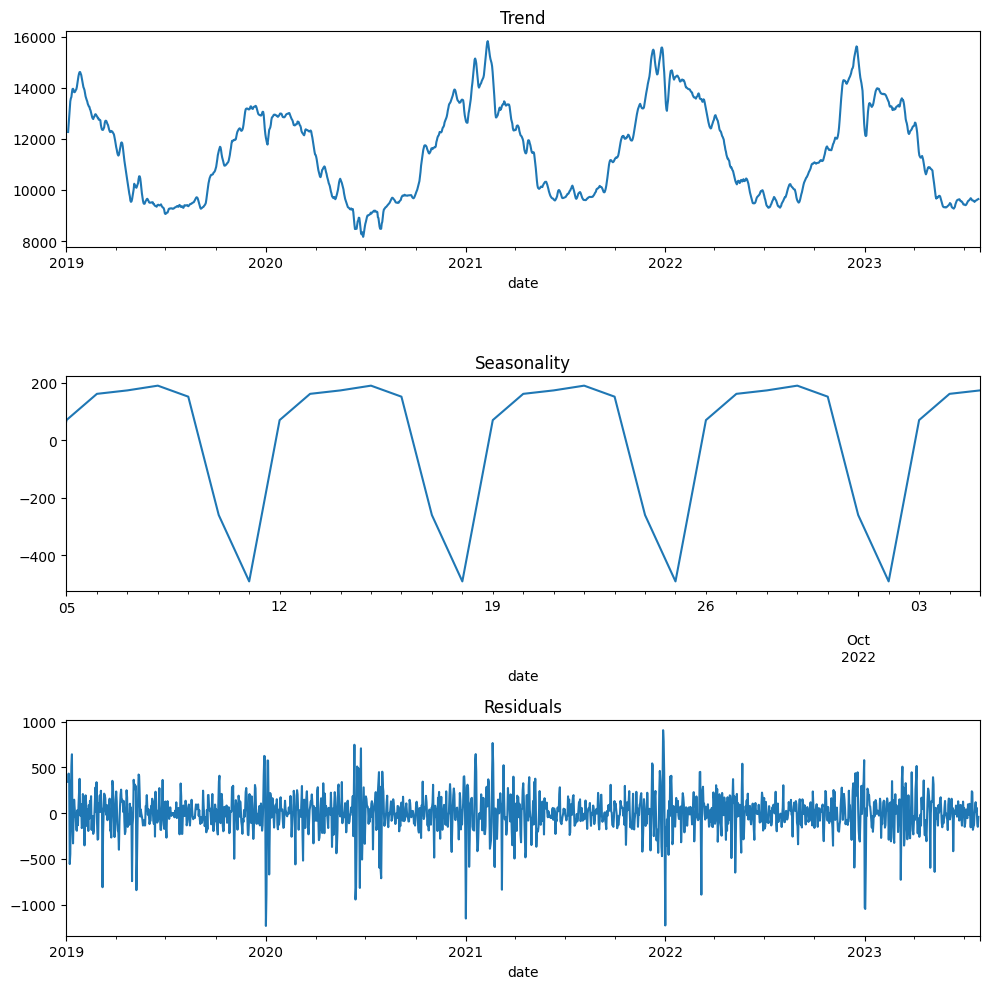

In [23]:
# Визуализация трендов,сезонности электропотребления во времени
decomposed = seasonal_decompose(data.set_index('date')[ 'target'].resample('1D').sum())

plt.figure(figsize=(10, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.xlim(['2022-09-05', '2022-10-05'])

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

- Тренд повторяется каждый год: зимой повышение, летом понижение потребления
- Недельная сезонность: понедельник - резкое повышение на все будние дни, снижение в выходные. Разница около ~500 МВт*ч
- В residuals также осталась закономерность - сильное падение в начале года - вероятно, в новогодние праздники

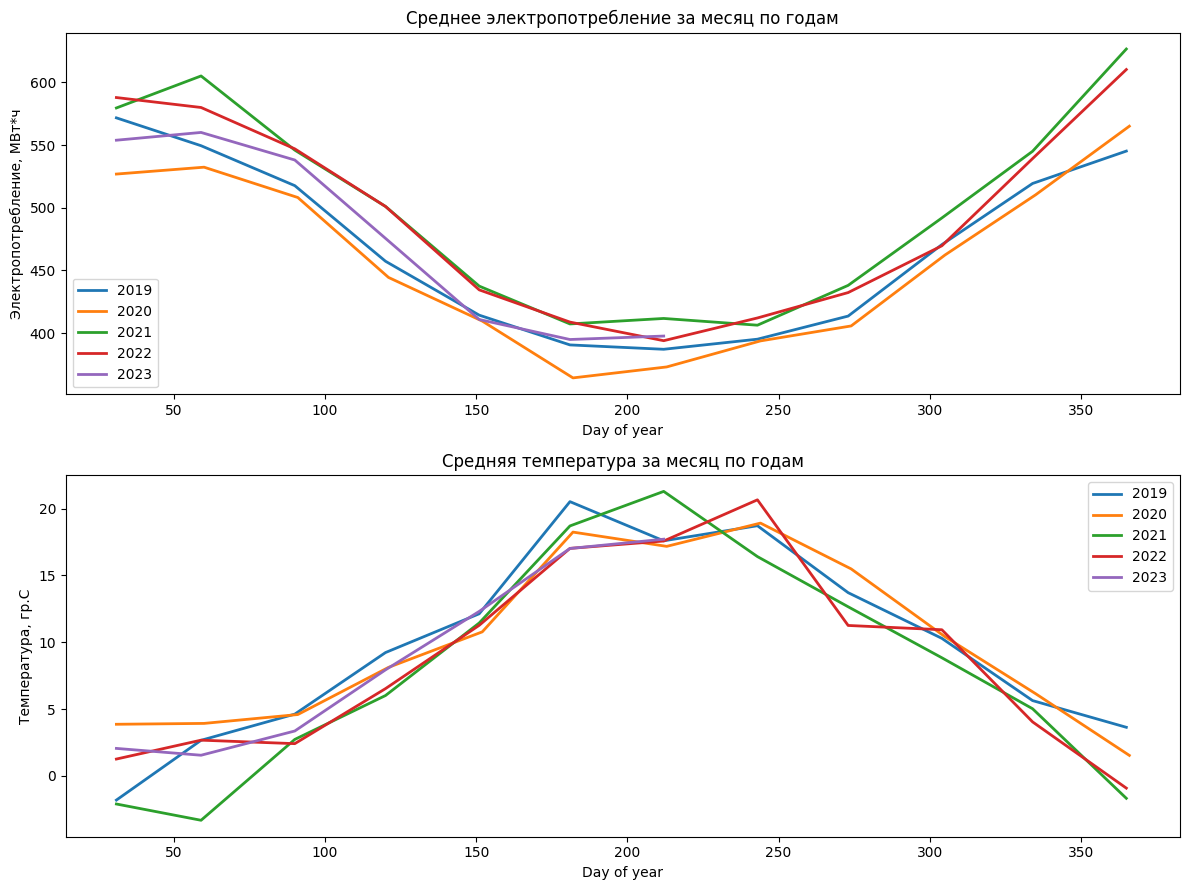

In [22]:
# графики распределения по годам средних за месяц потребления и фактической температуры
fig, axs = plt.subplots(2, 1, figsize=(12, 9))

for year in data['date'].dt.year.unique():
    df_year = data[data['date'].dt.year == year][['date', 'target', 'temp']]
    #  суммирование по месяцу
    df_year = df_year.set_index('date').resample('1M').mean()
    df_year['Day of year'] = df_year.index.dayofyear
    df_year = df_year.set_index('Day of year')[['target', 'temp']]
    # график потребления по годам
    df_year.plot(y='target', ax=axs[0], label=year, linewidth=2, 
                 ylabel='Электропотребление, МВт*ч').set_title('Среднее электропотребление за месяц по годам')
    # график средних температур за месяц по годам
    df_year.plot(y='temp', ax=axs[1], label=year, linewidth=2,
                 ylabel='Температура, гр.С').set_title('Средняя температура за месяц по годам')
plt.tight_layout()

- Подтверждаем цикличность по годам
- Чем ниже температура в холодный период, тем выше электропотребление.   
- В 2020  самое низкое потребление по месяцам и самые высокие температуры в холодный период, наоборот в 2021
- Последовательных изменений в хронологическом порядке не наблюдается, скорее всего, основной влияющий фактор - погода 


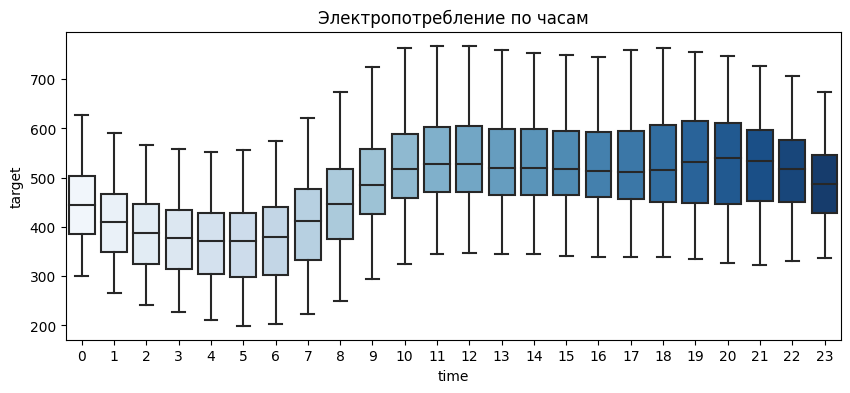

In [23]:
# потребление по часам в сутках
plt.figure(figsize=(10, 4))
sns.boxplot(data=data, x='time', y='target', palette='Blues').set_title('Электропотребление по часам')
plt.show()

- Сезонность по суткам: падение потребления ночью с 23 часов и повышение с 7 утра 

### Обработка текстовых признаков 'weather_pred'
(Признак  'weather_fact'  использовать не будем)

В признаке weather_pred более 2 тыс. уникальных значений, похоже, что признак заполняется вручную разными людьми. 

In [24]:
# выведем уникальные значения из weather_pred
data['weather_pred'].unique().tolist()[:15] # сократим вывод

['пасм, ветер',
 'пасм, 80% дождь',
 'пасм, ветер, 76% дождь',
 'пасм, ветер, снег',
 'пасм, 52% снег',
 'пасм, 24% дождь',
 'пасм, 36% снег',
 'пасм, 16% дождь',
 'пасм, 74% дождь,, снег',
 'прояснения?',
 'облачно',
 'пасм',
 'пасм, 40% снег',
 'пасм, 30% сн+дождь',
 'пасмурно']

В описании погоды много сокращений, одни и те же явления могут быть написаны по-разному, разный порядок слов,  есть записи без численного значения относительной влажности


Важный фактор повышения электропотребления - температура окружающей среды. Основные аспекты погоды, которые влияют на температуру и её ощущение: 
- **облачность**: ясно/солнечно, малооблачно/полуоблачно/с прояснениями, облачно, пасмурно 
- **ветер**: ветер ветрище
- **осадки и явления**: дождь/дождик, ливень, морось, снег/снежок/снегопад/пурга, метель, град, гроза, шторм, дымка, туман,  изморозь/лед/обледенение, иней
- **влажность**: численное значение

Очистим текст и оценим, как мы можем обрабатывать этот признак для передачи в модель. После попробуем отдельно выделить  численное значение вероятности осадков.

In [25]:
# функция для очистки текста
def preprocess_text(text):
    # перевести текст в нижний регистр
    text = text.lower()
    # заменить ё на е
    text.replace('ё', 'е')
    # оставляем только буквы 
    text = re.sub(r'[^а-я]', ' ', text)
    # Токенизация 
    text = nltk.word_tokenize(text)
    # Соединяем в текст 
    text = " ".join(text)
    # осттавить слова, содержащие не менее 3 символов
    text = re.sub(r'\b\w{1,2}\b', '', text)
    return text

In [26]:
# получим список всех очищенных слов 
words = data['weather_pred'].apply(lambda x: preprocess_text(x)).str.cat(sep=' ').split()
# прсчитаем как часто каждое слово встречается в объединённом датасете
count_words_array = np.unique(words, return_counts=True)
# таблица
words_table = pd.DataFrame(count_words_array[1], 
             index=count_words_array[0], 
             columns=['count']).sort_values(by='count',ascending=False)

print('Всего слов после очистки:', len(words_table))
words_table.head(35)

Всего слов после очистки: 62


,count
обл,13440
пасм,12652
ветер,10166
ясно,6662
дождь,4625
пасмурно,1990
снег,1986
облачно,1948
пер,1893
малообл,1883


Для кодирования очищенного текста применим **CountVectorizer**. В результате один столбец с текстовым описанием будет заменён на несколько бинарных признаков - часто встречающиеся очищенные слова.

In [27]:
# векторизация, записываем каждое слово weather_pred как отдельный столбец (наиболее часто встречающиеся слова)
def vectorize_weather_pred(data_test, count_vectorizer):
    data = data_test.copy()
    # очистили текст
    data['weather_pred'] = data['weather_pred'].fillna('').apply(lambda x: preprocess_text(x))

    # создаст матрицу: столбцы слова, значения бинарные
    text_vector = count_vectorizer.transform(data['weather_pred'])
    # преобразуем в датафрейм
    text_df = pd.DataFrame(text_vector.toarray(), columns=count_vectorizer.get_feature_names_out())
    # присодиним к основному датасету
    data = pd.concat([data, text_df], axis=1)
    # удалим признак weather_pred
#     data = data .drop('weather_pred', axis=1)
    return data

In [28]:
# обучим векторайзер: оставит слова с частоттой появления 0.001 во всём датасете
count_vectorizer = CountVectorizer(min_df=0.001) 
# создаст матрицу: столбцы слова, значения бинарные
count_vectorizer.fit(data['weather_pred'].apply(lambda x: preprocess_text(x)))
data_vec = vectorize_weather_pred(data, count_vectorizer)
display(data_vec.head(2), data_vec.shape)

,date,time,target,temp,temp_pred,weather_pred,weather_fact,ветер,ветерок,ветрище,...,пасмурно,пер,проясн,прояснения,сев,снег,снегопад,солнечно,шторм,ясно
0,2019-01-01,0,481.510,2.9,2.0,пасм ветер,ветер,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01,1,462.872,2.9,2.0,пасм ветер,ветер,1,0,0,...,0,0,0,0,0,0,0,0,0,0


(40152, 30)

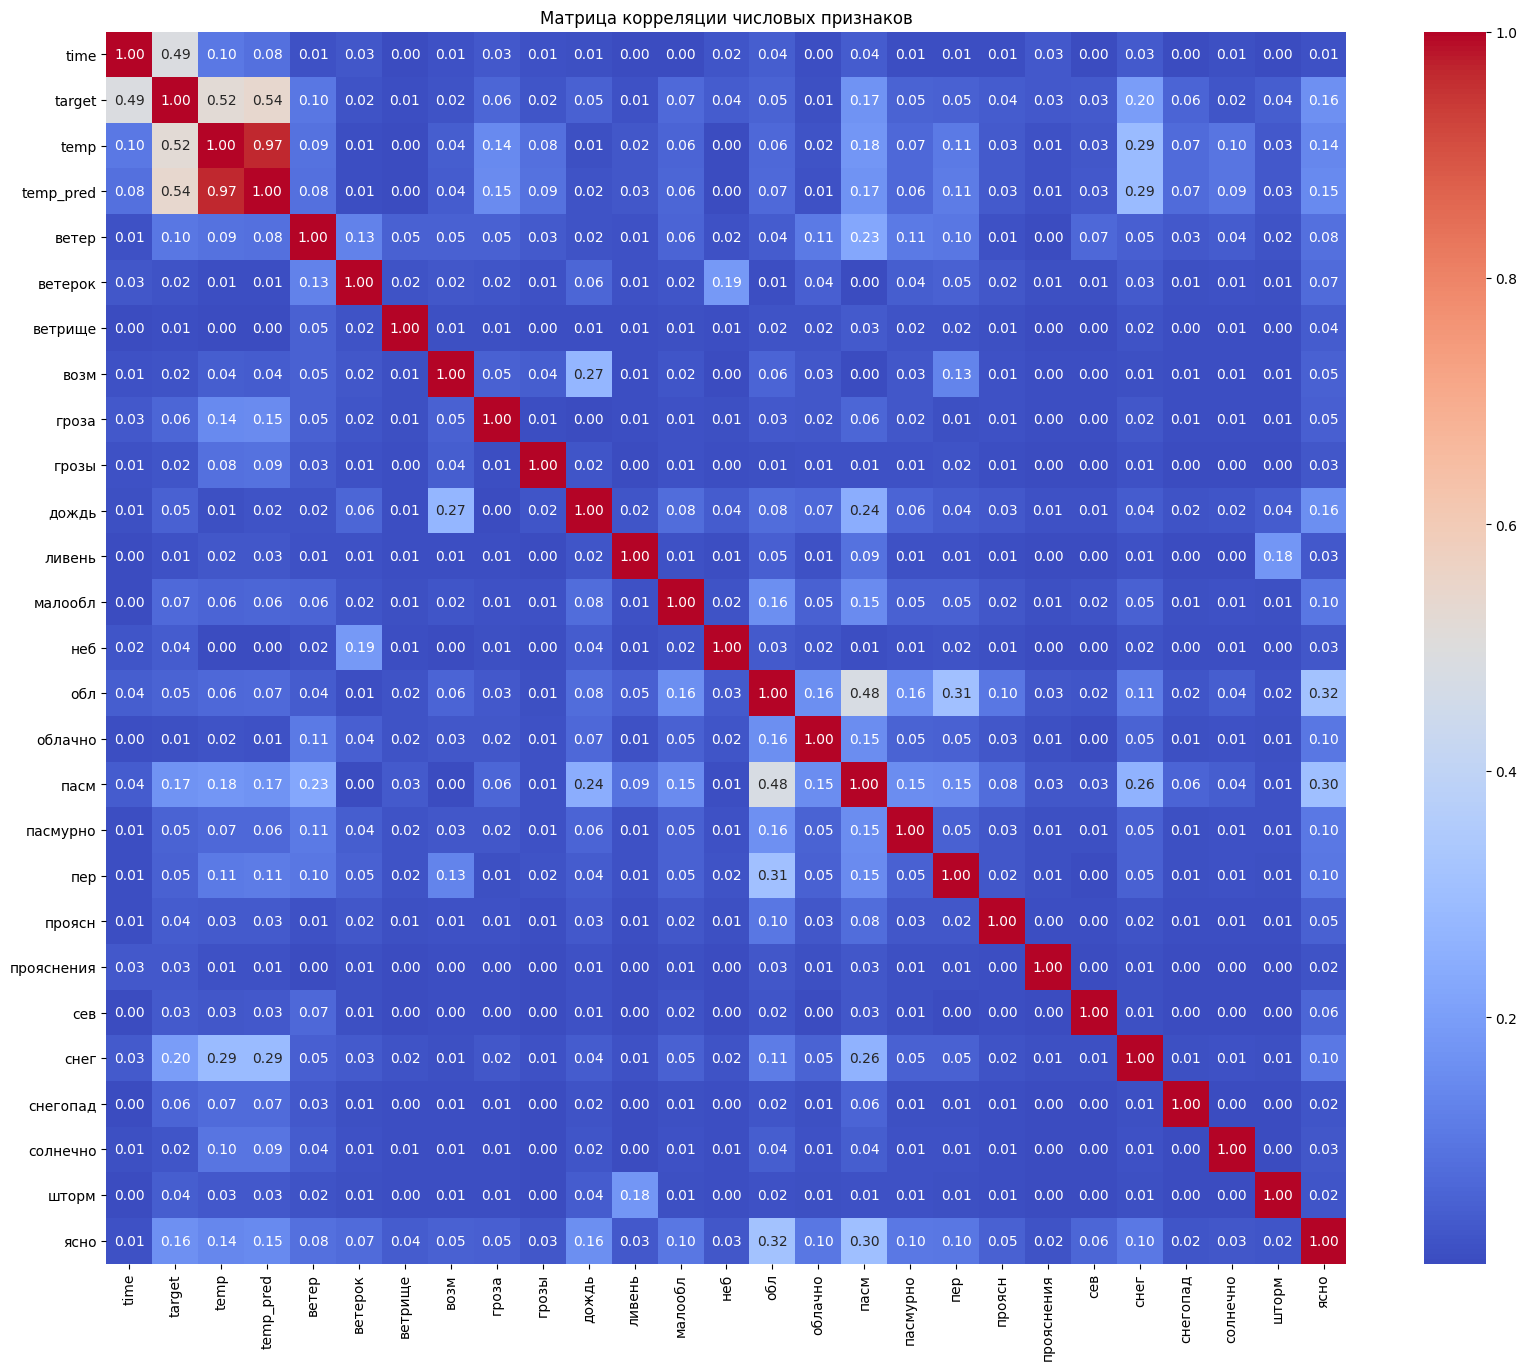

In [29]:
correlation_matrix = data_vec.corr(numeric_only=True, method='spearman')

plt.figure(figsize=(20, 16))
sns.heatmap(abs(correlation_matrix), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции числовых признаков')
plt.show()


### Feature engineering
Сгенерирум новые признаки и исследуем взаимосвязи
- Календарные признаки: 
    - dayofweek
    - quarter
    - month
    - year
    - dayofyear
    - dayofmonth
    - weekofyear
    - season
    - morning
    - day
    - evening
    - night
- Лаговые признаки:
    - лаги с разницей в 1, 2, 3, 4, 5, 6, 7, 365 (1 год), 730(2 года) дней, 
    - скользящее среднее за предыдущие 7 дней в этот час,  
    - разница таргета между значением в предыдущий день и его предыдущим часом, разница таргета между этим же часов в два предыдущих дня, разница таргета значением предыдущего дня этого года и предыдущего
- Флаг выходного дня 

In [30]:
# функция достать относительную влажность из описания погоды - это вероятность осадков =)
def humidity_from_text_weather(dataset):
    data = dataset.copy()
    # оставляем только цифры, переводим в float    
    data['humidity'] = data['weather_pred'].fillna('').apply(lambda text: re.sub(r'[^0-9]', ' ', text))
    data['humidity'] = pd.to_numeric(data['humidity'], errors='coerce')
    data.loc[data['humidity']>100, 'humidity'] = np.nan
    return data

# календарные признаки
def create_features(data):
    data = data.copy()
    data['dayofweek'] = data.date.dt.dayofweek
    data['quarter'] = data.date.dt.quarter
    data['month'] = data.date.dt.month
    data['year'] = data.date.dt.year
    data['dayofyear'] = data.date.dt.dayofyear
    data['dayofmonth'] = data.date.dt.day
    data['weekofyear'] = data.date.dt.isocalendar().week.astype(int)
    data['season'] = data['month'].apply(lambda month_number: (month_number%12 + 3)//3)

    # флаг выходного дня подтягивается из внешней таблицы по дате
    # загрузим таблицу всех выходных: викенд и праздники
    holiday_table = pd.read_csv('holidays_calendar.csv', parse_dates=['date']) 
    # добавим признак выходного дня
    data = data.merge(holiday_table[['date','holiday']], on='date', how='left')
    #  если в таблице не окажется нужной даты, заполнится наном? если наном, то для lgbm ок, если ошибка - прописать try/except
    #  data['holiday'] = data['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)
    
    # ухудшают метрику
    # время суток
    data['morning'] = ((data['time'] >= 6) & (data['time'] < 12)).astype(int)
    data['day'] = ((data['time'] >= 12) & (data['time'] < 18)).astype(int)
    data['evening'] = ((data['time'] >= 18) & (data['time'] <= 23)).astype(int)
    data['night'] = ((data['time'] >= 0) & (data['time'] < 6)).astype(int)

    return data#.drop('date', axis=1)

def create_lag_rolling(data):
    new_data = data.copy()
    # лаги  
    for lag in [1, 2, 3, 4, 5, 6, 7, 365, 730]:
        new_data['lag_day_'+str(lag)] = new_data['target'].shift(lag*24)
    # лаги погоды
    new_data['temp_lag'] = new_data['temp'].shift(24)
    # скользящее среднее за предыдущие 7 дней в тот же час
    for hour in range(0, 24):
        new_data.loc[new_data['time'] == hour, 'roling'] =\
                        new_data.loc[new_data['time'] == hour, 'target'].shift().rolling(7).mean()
    
    # ухудшают метрику
    # разница таргета между значением в предыдущий день и его предыдущим часом
    new_data['diff_hour'] = new_data['target'].shift(24) - new_data['target'].shift(25)
    # разница таргета между этим же часов в два предыдущих дня 
    new_data['diff_day'] = new_data['target'].shift(24) - new_data['target'].shift(48)
    # разница таргета значением предыдущего дня этого года и предыдущего
    new_data['diff_year'] = new_data['target'].shift(24) - new_data['target'].shift(24*365)

    return new_data#.drop(['temp', 'weather_fact'], axis=1)

# функция для генерации признаков
def feature_engineering_func(dataset):
    df = dataset.copy()

    # влажность
    df = humidity_from_text_weather(df)

    # календарные признаки
    df = create_features(df)

    # лаговые
    df = create_lag_rolling(df)
    
    return df

In [31]:
data = feature_engineering_func(data)
data.sample(5).T

,30834,19565,20289,13476,20256
date,2022-07-08 00:00:00,2021-03-26 00:00:00,2021-04-25 00:00:00,2020-07-15 00:00:00,2021-04-24 00:00:00
time,18,5,9,12,0
target,430.447,435.522,461.735,455.891,475.127
temp,18.0,-1.7,7.0,25.0,-0.6
temp_pred,17.0,2.0,7.0,24.0,2.0
weather_pred,"обл.,возм.дождь 0,6мм","обл, 16%","пасм, 56% дождь",малообл,"обл, ветер"
weather_fact,пер.обл.,туман,"обл с пр, ветер",ясно,"обл с пр, ветер"
humidity,NaN,16.0,56.0,NaN,NaN
dayofweek,4,4,6,2,5
quarter,3,1,2,3,2


### Корреляционный анализ
Построим матрицу корреляции между числовыми признаками и оценим взаимосвязи между ними:

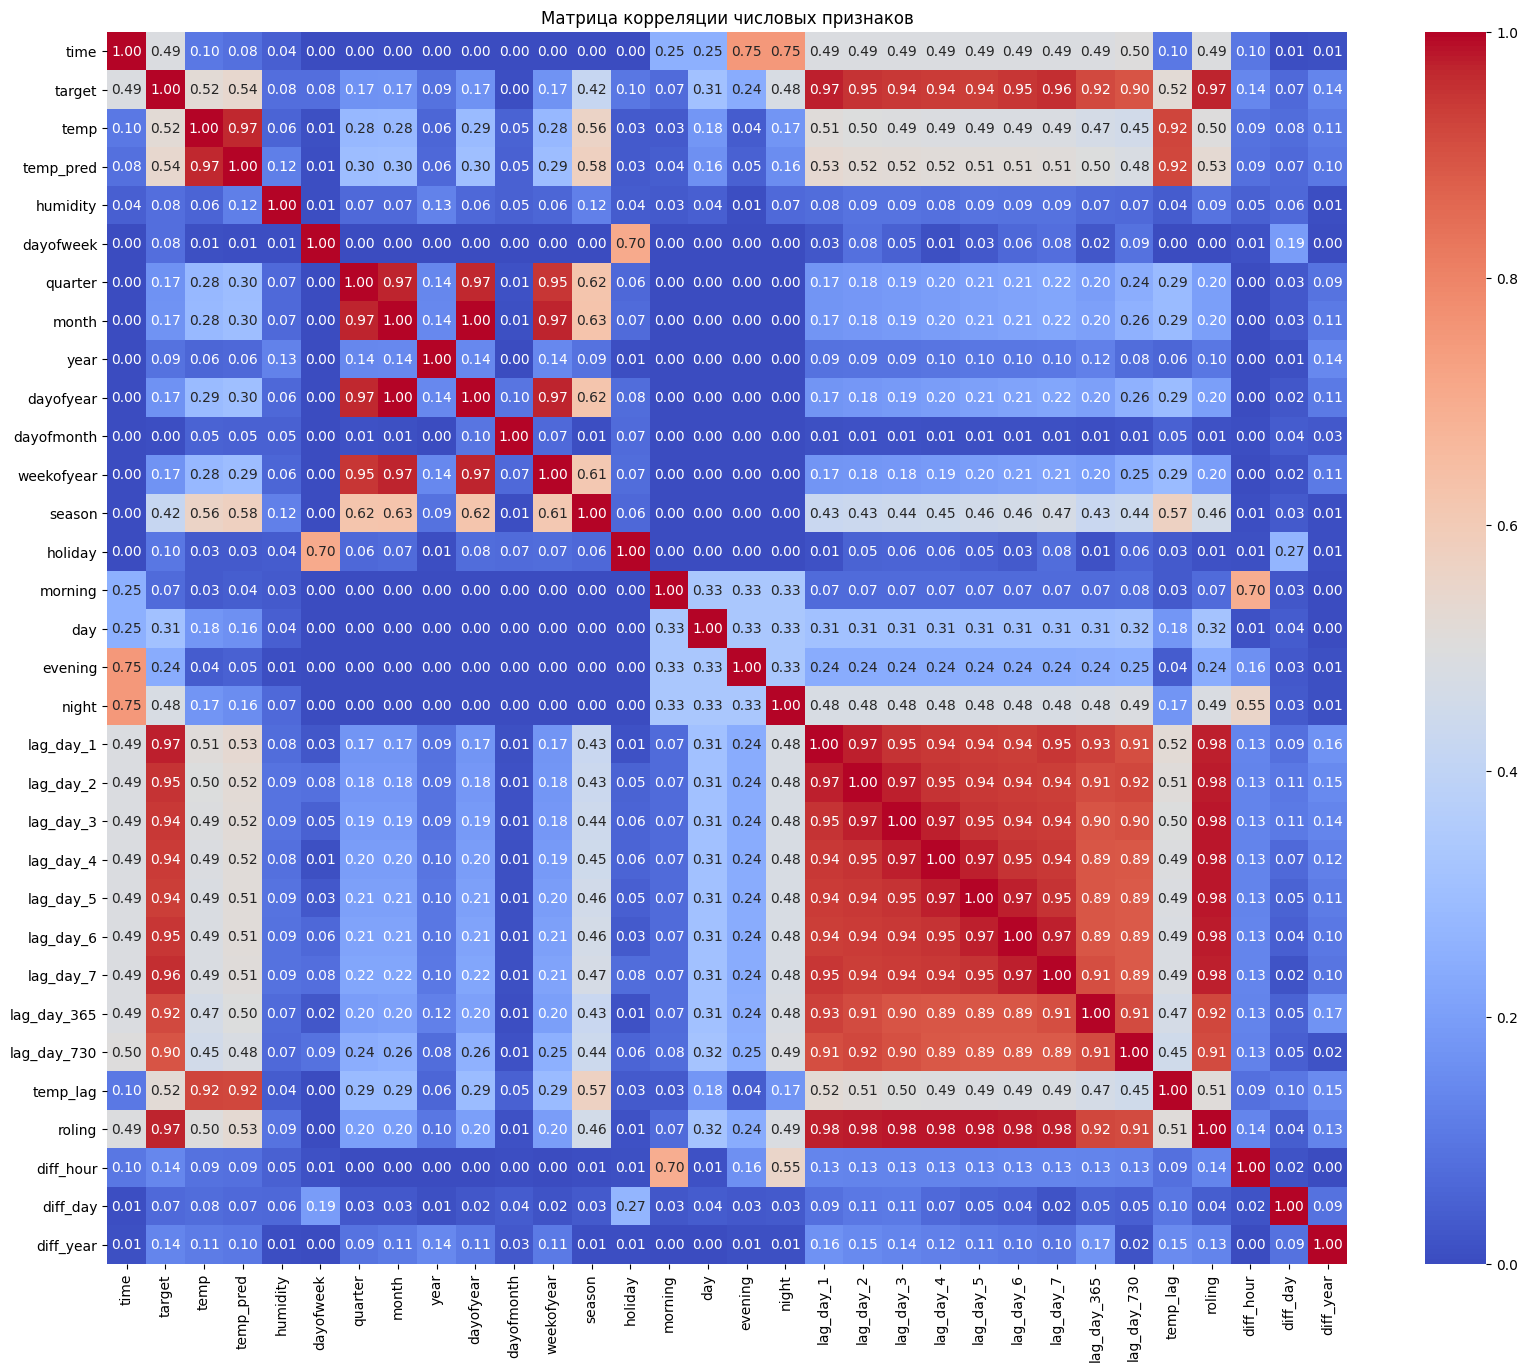

In [32]:
correlation_matrix = data.corr(numeric_only=True, method='spearman')

plt.figure(figsize=(20, 16))
sns.heatmap(abs(correlation_matrix), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции числовых признаков')
plt.show()

Целевой признак имеет слабые линейные зависимости с часом суток и признаком "ночь", температурами, сезоном и сильные с лаговыми признаками

Визуализируем взаимосвязь между температурой и электропотреблением

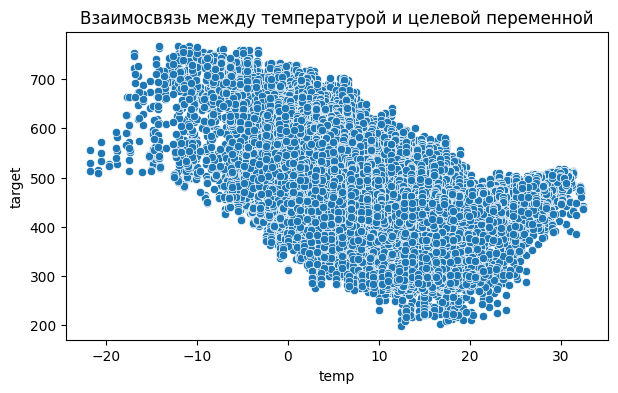

In [33]:
plt.figure(figsize=(7, 4))
sns.scatterplot(x='temp', y='target', data=data)
plt.title('Взаимосвязь между температурой и целевой переменной')
plt.show()

Отрицательная зависимость: с понижением температуры повышается потребление. Но после +20 градусов видим перелом и увеличение потребления с повышением температуры. Это может объясняться необходимостью охлаждения помещений в жаркую погоду (кондиционеры)

interval columns not set, guessing: ['time', 'target', 'temp', 'temp_pred', 'humidity', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'season', 'holiday', 'morning', 'day', 'evening', 'night', 'lag_day_1', 'lag_day_2', 'lag_day_3', 'lag_day_4', 'lag_day_5', 'lag_day_6', 'lag_day_7', 'lag_day_365', 'lag_day_730', 'temp_lag', 'roling', 'diff_hour', 'diff_day', 'diff_year']


/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/phik/simulation.py:28: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def sim_2d_data(hist:np.ndarray, ndata:int=0) -> np.ndarray:
/Users/thetonytime/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/phik/simulation.py:28: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def sim

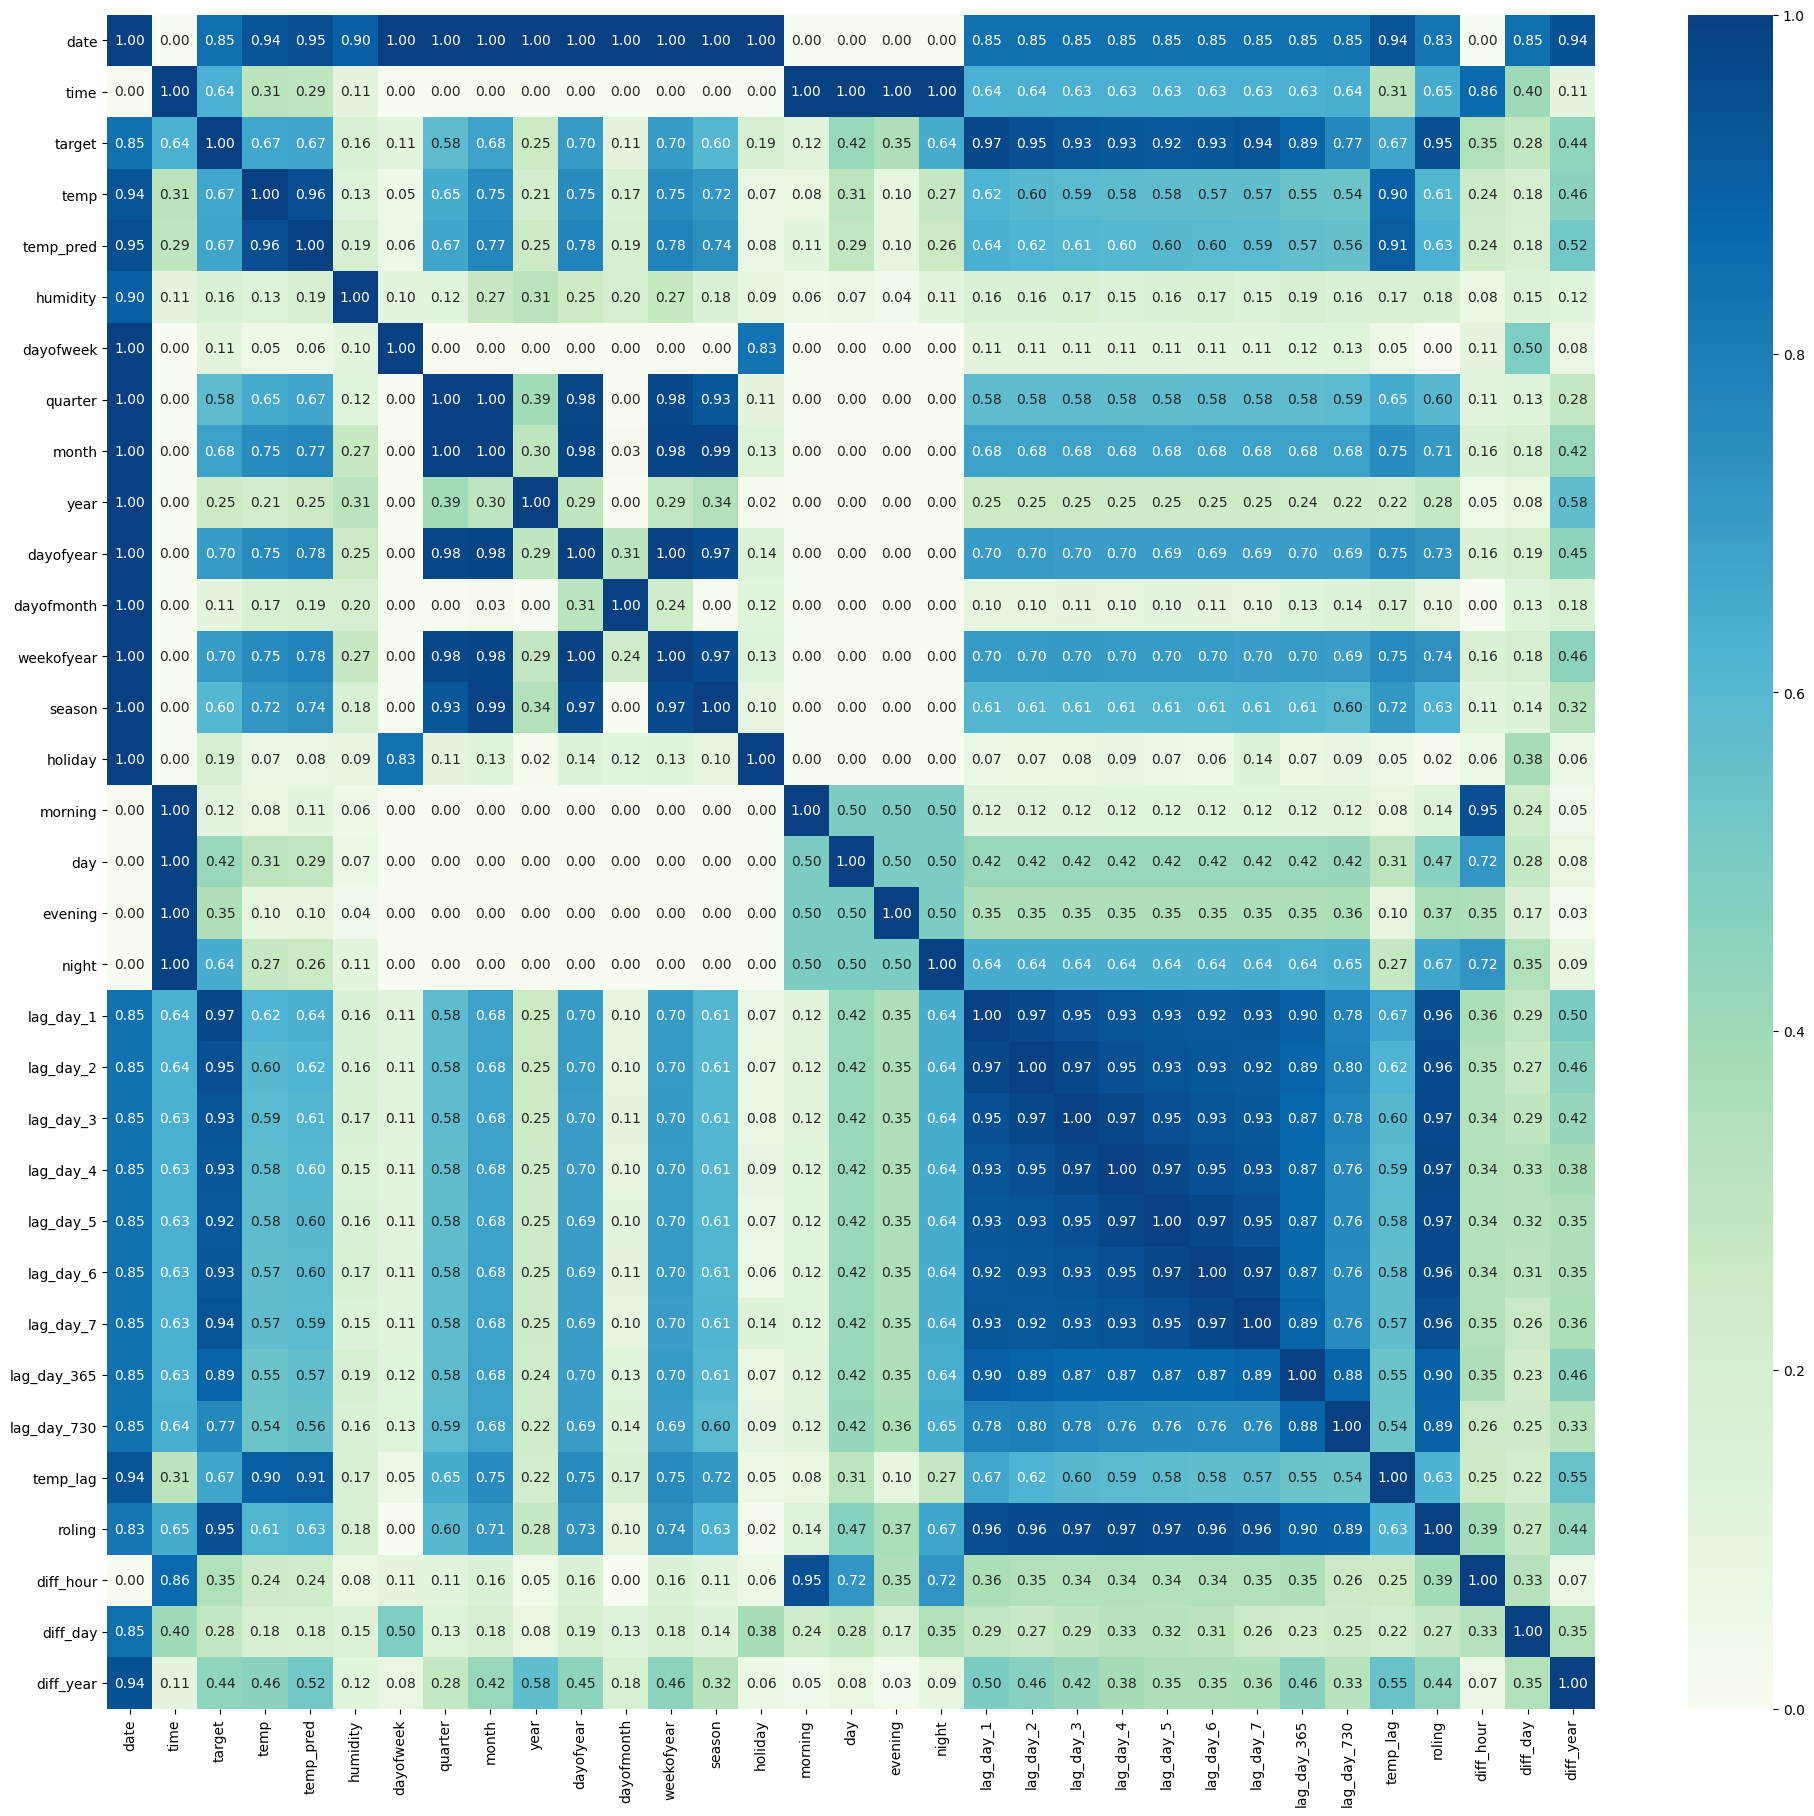

In [34]:
# коэффициенты корреляции фи 
corr_phik = data.drop(['weather_pred', 'weather_fact'], axis=1).phik_matrix()
plt.figure(figsize=(24, 22))
sns.heatmap(corr_phik, annot=True, cmap="GnBu", fmt=".2f")
None

У целевого признака выявлена статистическая взаимосвязь почти со всеми признаками (кроме нескольких календарных и влажности).

Решено оставить для обучения все признаки

---
**Итоги исследовательского анализа данных:** 

Временной ряд:
- 4 с половиной года, последовательный, полный и стационарный.
- Сезонности:
    - годовая: спад летом, повышение зимой, выбивающееся понижение в новогодние праздники
    - недельная: повышение в будни, спад в выходные
    - дневная: повышение днём с 7 до 23, понижение ночью
    - закономерные выпады в  период новогодних праздников
- Последовательных изменений по годам не наблюдается, наиболее вероятнго, что основной влияющий фактор погода. Чем ниже температура в холодный период, тем выше электропотребление.   

Погода:  
- Важный фактор повышения электропотребления - температура окружающей среды и, следовательно, другие аспекты погоды, которые влияют на температуру и её ощущение: облачность (влияет на освещение), ветер, осадки, влажность.
- Целевой признак с температурой имеет отрицательную зависимость: с понижением температуры повышается потребление. Но после +20 градусов видим перелом и уже увеличение потребления с повышением температуры (охлаждение помещений в жаркую погоду)
- Текствовый столбец с описанием прогнозируемой погоды weather_pred заполняется вручную, из-за чего содержит много уникальных значений. Для сохранения информации из признака закодируем его с помощью CountVectorizer с предварительной очисткой. В результате получим ряд бинарных признаков, которые представляют собой часто встречающиеся очищенные слова с флагом их появления в описании.
- Из weather_pred выделен признак с относительной влажностью. Так как значение влажности указано не везде, то признак будет содержать много пропусков, что решим использованием модели, способной их обрабатывать.

Новые признаки:
- Дополнительно были сгенерированы календарные и лаговые признаки
- Целевой признак имеет сильные линейные зависимости с лаговыми признаками и слабые с часом суток и признаком "ночь", температурами, сезоном. Нелинейные зависимости в разном проявлении имеются почти со всеми признаками.
